## ASK joint: pertpy cell type priorization

In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

Running Scanpy 1.9.1, on 2022-11-27 13:29.


In [2]:
## path variables
adata_dir = '/home/niklas/data/220107_Human_PCLS_ASK_joint/220107_PCLS_human_ASK_joint_annotated_NIKLAS.h5ad'

In [3]:
## plotting variables
sc.settings.figdir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/'
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## load anndata object
adata = sc.read(adata_dir)

In [5]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 63581 × 17343
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

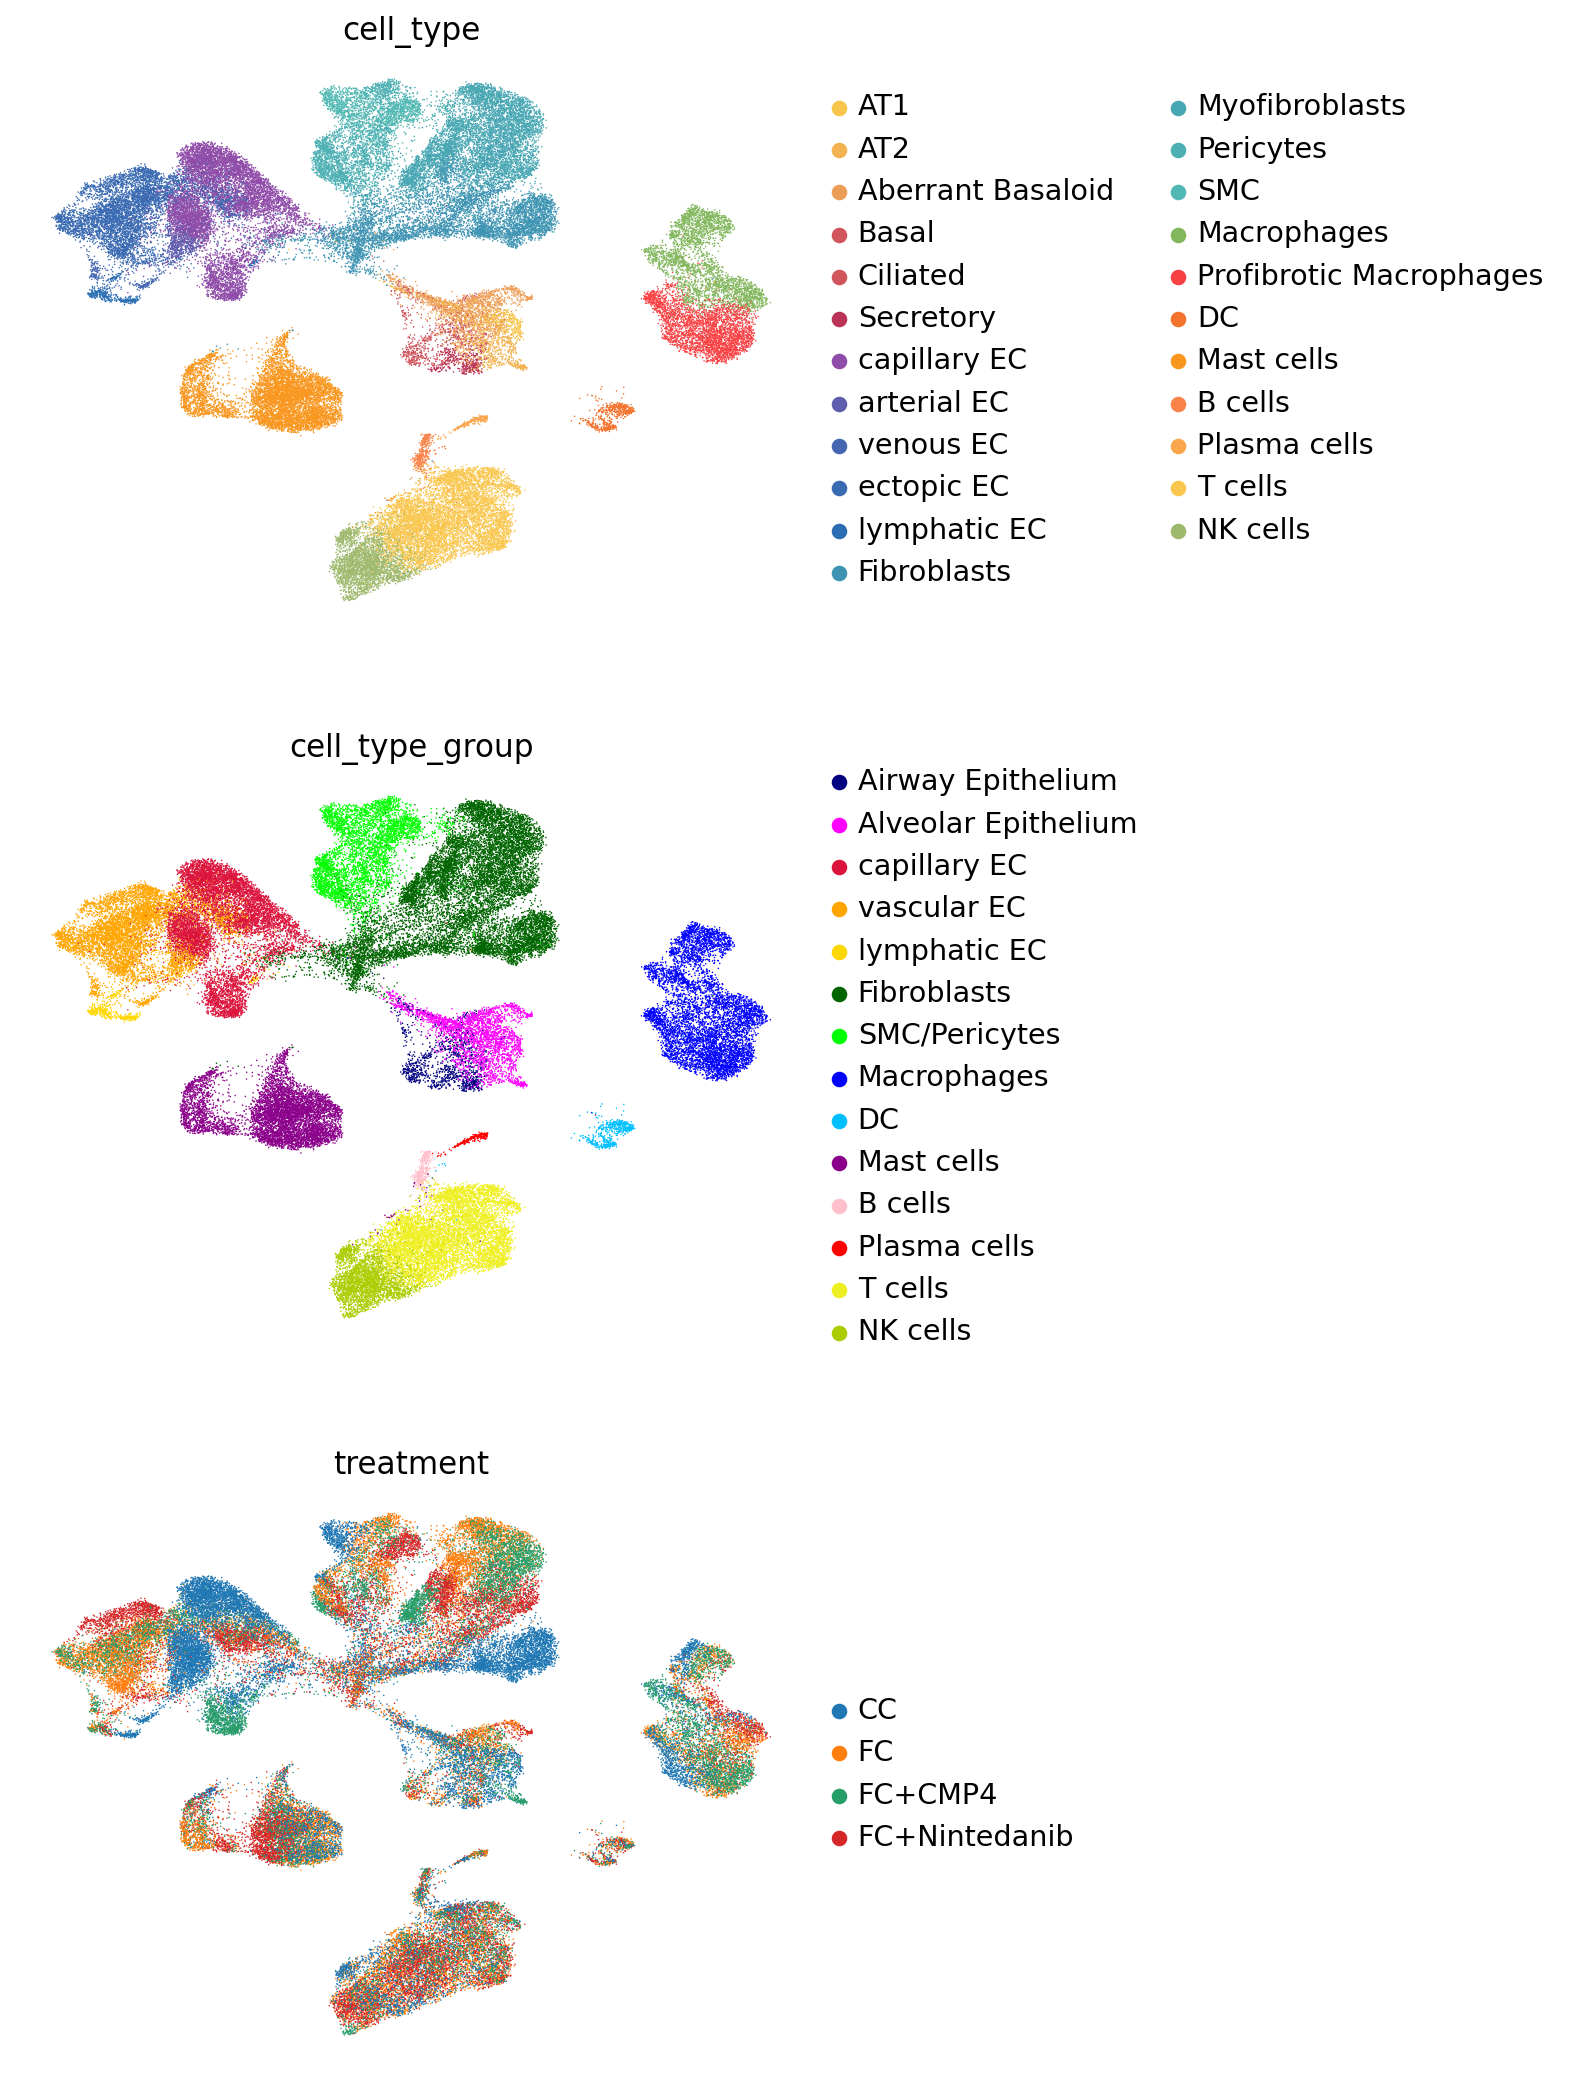

In [6]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type','cell_type_group','treatment'], ncols = 1, frameon = False)

In [7]:
pd.crosstab(adata.obs['treatment'],adata.obs['cell_type_group'])

cell_type_group,Airway Epithelium,Alveolar Epithelium,capillary EC,vascular EC,lymphatic EC,Fibroblasts,SMC/Pericytes,Macrophages,DC,Mast cells,B cells,Plasma cells,T cells,NK cells
treatment,,,,,,,,,,,,,,
CC,403,1136,5476,827,154,3953,975,1540,72,875,89,54,988,548
FC,405,797,658,3149,154,3311,1482,1894,218,2660,114,85,2898,1204
FC+CMP4,195,604,1375,1272,115,3079,918,2179,102,1064,110,48,1248,329
FC+Nintedanib,166,329,898,1664,104,3401,1358,832,159,2369,92,39,2522,891


In [8]:
pd.crosstab(adata.obs['treatment'],adata.obs['cell_type'])

cell_type,AT1,AT2,Aberrant Basaloid,Basal,Ciliated,Secretory,capillary EC,arterial EC,venous EC,ectopic EC,...,Pericytes,SMC,Macrophages,Profibrotic Macrophages,DC,Mast cells,B cells,Plasma cells,T cells,NK cells
treatment,,,,,,,,,,,,,,,,,,,,,
CC,276,431,429,176,53,174,5476,582,146,99,...,399,576,845,695,72,875,89,54,988,548
FC,90,16,691,50,159,196,658,12,42,3095,...,1120,362,777,1117,218,2660,114,85,2898,1204
FC+CMP4,53,185,366,58,84,53,1375,4,72,1196,...,741,177,937,1242,102,1064,110,48,1248,329
FC+Nintedanib,27,8,294,23,77,66,898,0,25,1639,...,652,706,560,272,159,2369,92,39,2522,891


In [9]:
## random forest classifier for categorical 'treatment' variable
ag_rfc = pt.tl.Augurpy('random_forest_classifier')

In [10]:
# select cell from conserved cell circuit only
adata = adata[adata.obs.cell_type.isin(['Aberrant Basaloid','Myofibroblasts','ectopic EC','Profibrotic Macrophages','Pericytes'])]

In [11]:
adata1 = adata[adata.obs.treatment.isin(['FC','FC+Nintedanib'])].copy()
adata2 = adata[adata.obs.treatment.isin(['FC','FC+CMP4'])].copy()

In [12]:
## Nintedanib subset: rename labels for adata
#adata1.obs['cell_type'] = adata1.obs['cell_type_group']
adata1.obs['label'] = adata1.obs['treatment']

In [13]:
## cmp4 subset: rename labels for adata
#adata2.obs['cell_type'] = adata2.obs['cell_type_group']
adata2.obs['label'] = adata2.obs['treatment']

In [14]:
## load data
loaded_data1 = ag_rfc.load(adata1)
loaded_data2 = ag_rfc.load(adata2)

In [15]:
loaded_data1.var['name'] = loaded_data1.var_names

In [16]:
loaded_data2.var['name'] = loaded_data2.var_names

In [17]:
nintedanib_adata, nintedanib_results = ag_rfc.predict(
    loaded_data1, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True)

nintedanib_results["summary_metrics"]

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

,ectopic EC,Aberrant Basaloid,Pericytes,Myofibroblasts,Profibrotic Macrophages
mean_augur_score,0.617063,0.709161,0.650975,0.656247,0.685204
mean_auc,0.617063,0.709161,0.650975,0.656247,0.685204
mean_accuracy,0.577564,0.658755,0.598901,0.598205,0.611520
mean_precision,0.611466,0.676281,0.637784,0.624850,0.674828
mean_f1,0.534457,0.638792,0.541831,0.550572,0.532406
mean_recall,0.527302,0.648175,0.521825,0.543810,0.490476


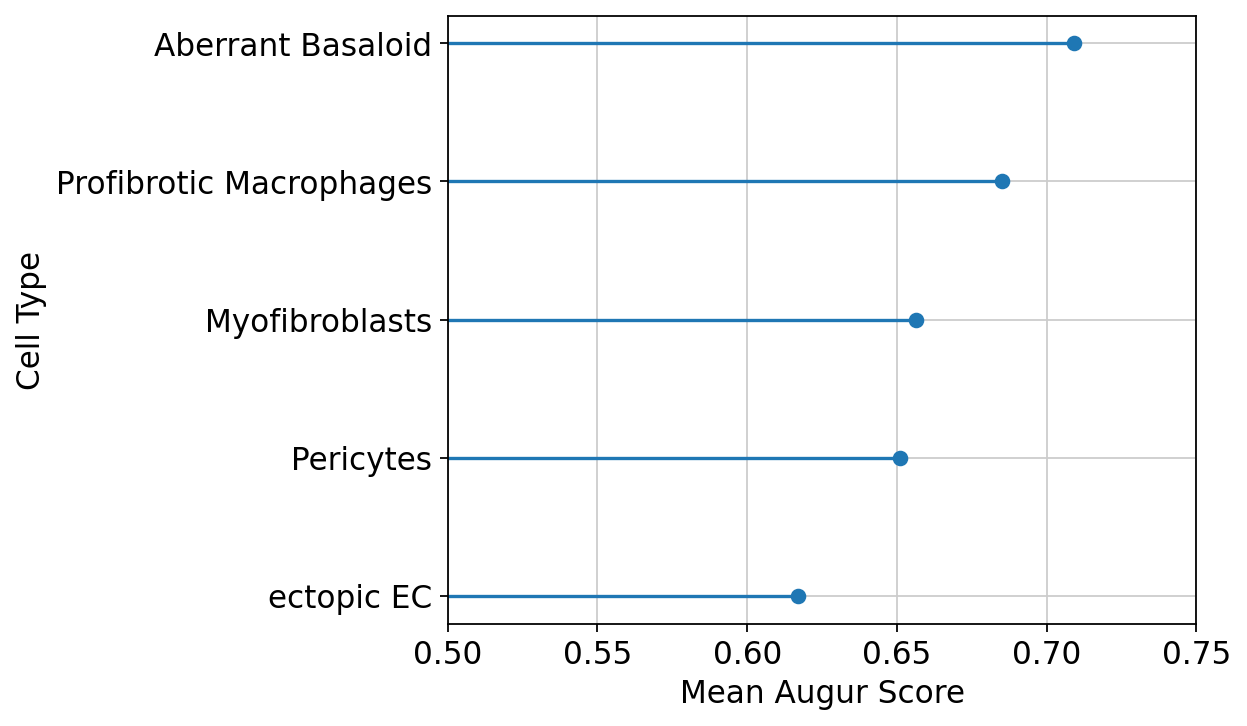

In [18]:
pt.pl.ag.lollipop(nintedanib_results)
plt.xlim([0.5, 0.75])
plt.savefig('/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/ASK_joint/pertpy_predictions/pertpy_nintedanib_lollipop.pdf')

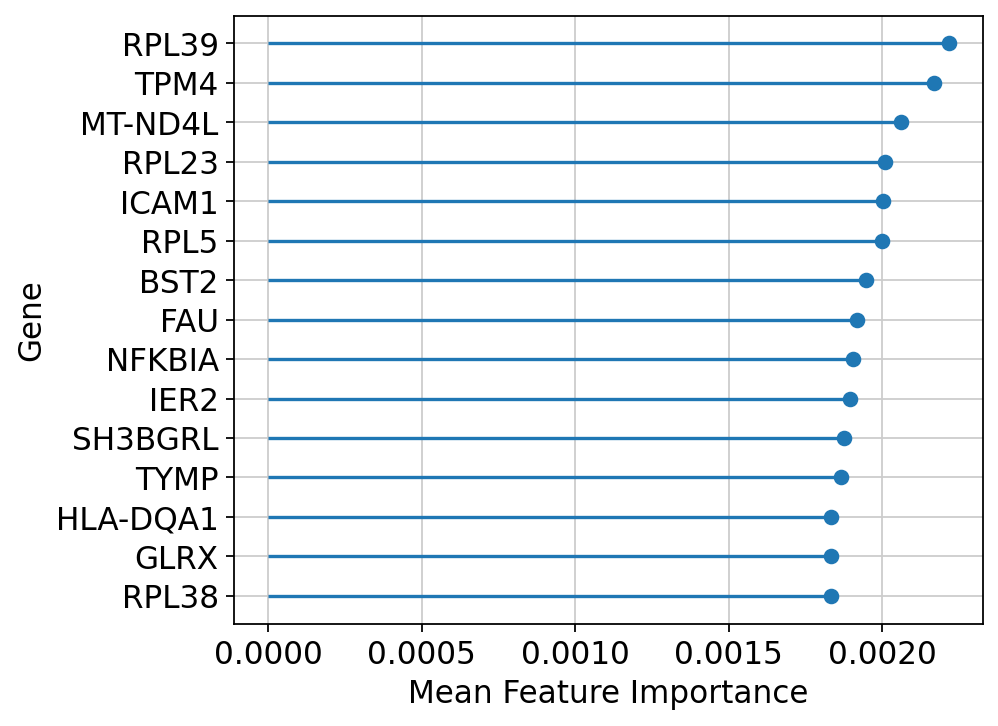

In [19]:
important_features = pt.pl.ag.important_features(nintedanib_results, top_n=15)

In [20]:
loaded_data2.var['name'] = loaded_data2.var_names

In [21]:
cmp4_adata, cmp4_results = ag_rfc.predict(
    loaded_data2, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

cmp4_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

,ectopic EC,Aberrant Basaloid,Pericytes,Myofibroblasts,Profibrotic Macrophages
mean_augur_score,0.566202,0.618974,0.599966,0.605998,0.608923
mean_auc,0.566202,0.618974,0.599966,0.605998,0.608923
mean_accuracy,0.526813,0.581245,0.560861,0.563040,0.567326
mean_precision,0.530447,0.602338,0.578385,0.577234,0.567151
mean_f1,0.510308,0.567900,0.502696,0.527190,0.565782
mean_recall,0.540159,0.584444,0.483254,0.532698,0.613016


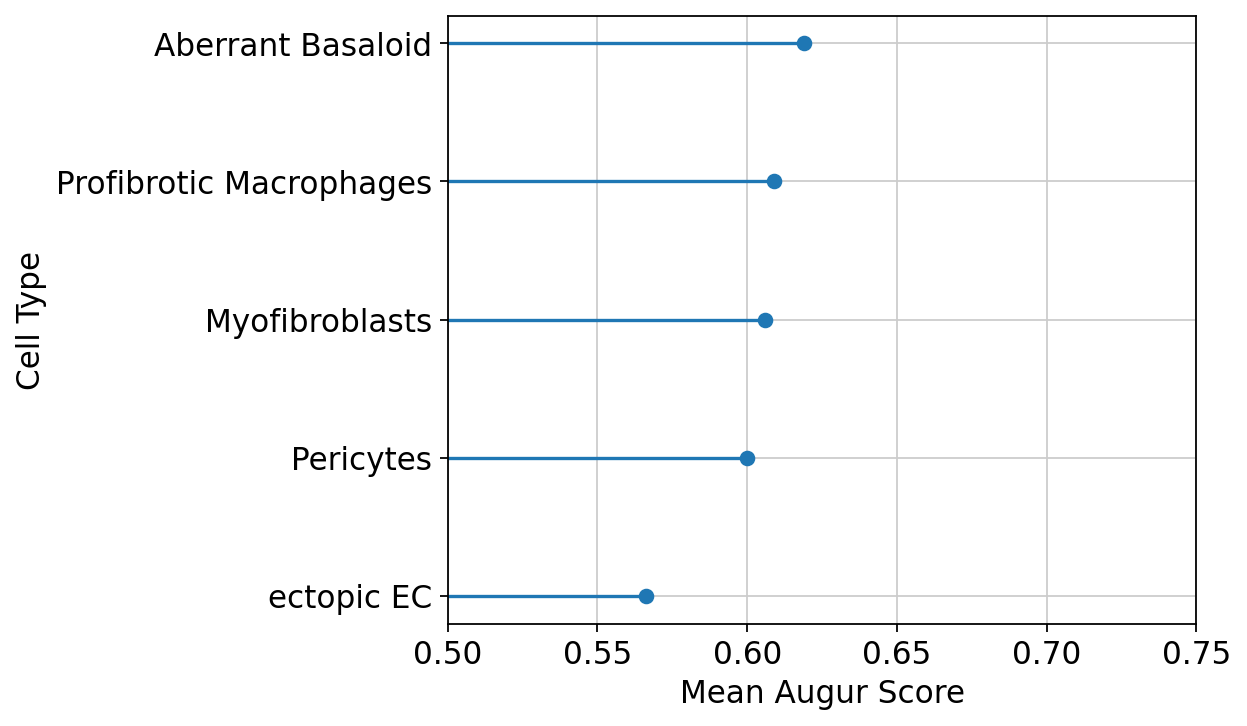

In [22]:
pt.pl.ag.lollipop(cmp4_results)
plt.xlim([0.5, 0.75])
plt.savefig('/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/ASK_joint/pertpy_predictions/pertpy_cmp4_lollipop.pdf')

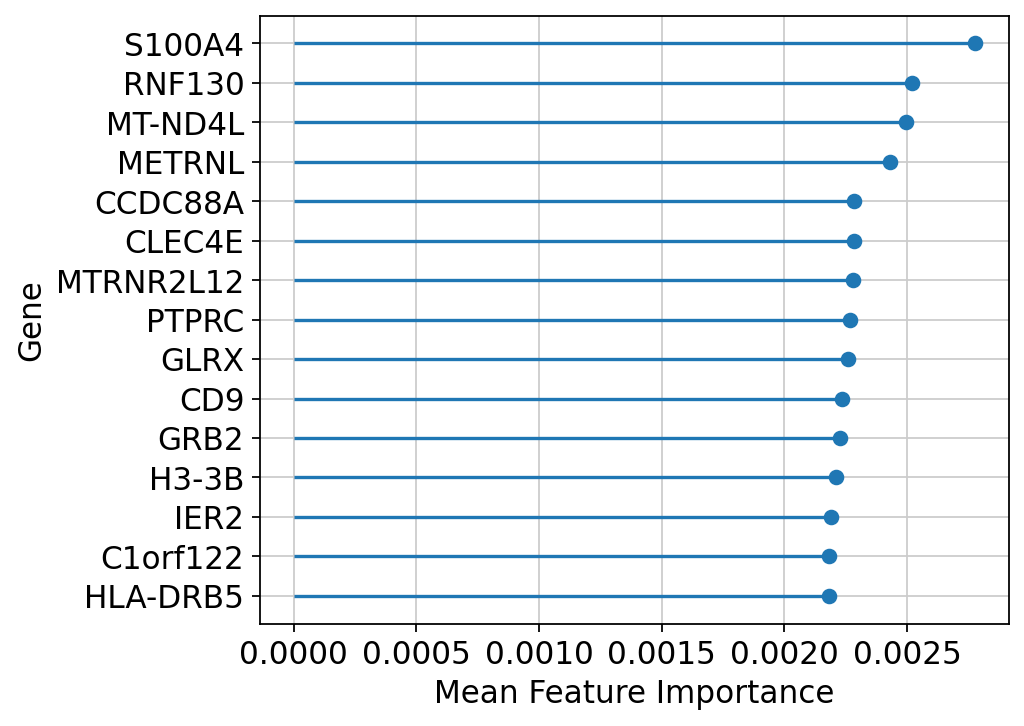

In [23]:
important_features = pt.pl.ag.important_features(cmp4_results, top_n=15)

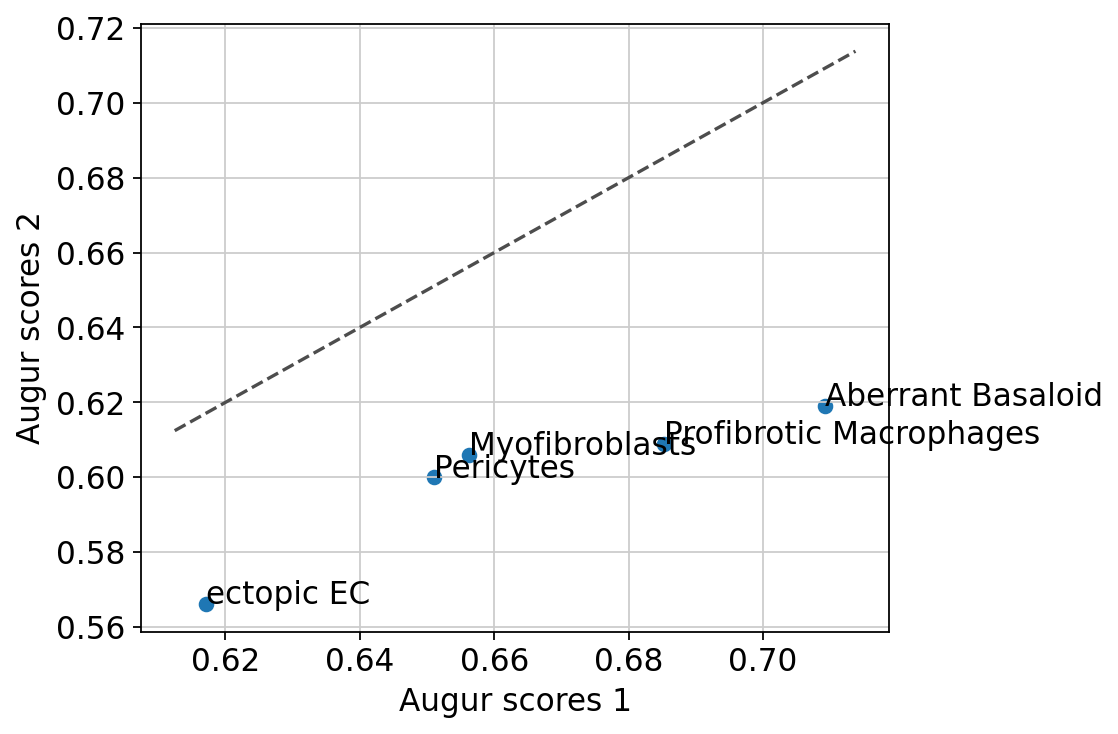

In [24]:
### plot augur score of Nintedanib vs CMP4 perturbation
pt.pl.ag.scatterplot(nintedanib_results, cmp4_results)
plt.savefig('/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/ASK_joint/pertpy_predictions/pertpy_nintedanib_vs_cmp4_lollipop.pdf')

In [25]:
nintedanib_scores = nintedanib_results['summary_metrics'].loc['mean_augur_score',]
cmp4_scores = cmp4_results['summary_metrics'].loc['mean_augur_score',]

In [26]:
nintedanib_scores = pd.DataFrame(nintedanib_scores)
nintedanib_scores['treatment'] = 'Nintedanib'
nintedanib_scores.reset_index(inplace=True)
nintedanib_scores.rename(columns = {'index':'cell_type'}, inplace = True)
nintedanib_scores

,cell_type,mean_augur_score,treatment
0,ectopic EC,0.617063,Nintedanib
1,Aberrant Basaloid,0.709161,Nintedanib
2,Pericytes,0.650975,Nintedanib
3,Myofibroblasts,0.656247,Nintedanib
4,Profibrotic Macrophages,0.685204,Nintedanib


In [27]:
cmp4_scores = pd.DataFrame(cmp4_scores)
cmp4_scores['treatment'] = 'cmp4'
cmp4_scores.reset_index(inplace=True)
cmp4_scores.rename(columns = {'index':'cell_type'}, inplace = True)
cmp4_scores

,cell_type,mean_augur_score,treatment
0,ectopic EC,0.566202,cmp4
1,Aberrant Basaloid,0.618974,cmp4
2,Pericytes,0.599966,cmp4
3,Myofibroblasts,0.605998,cmp4
4,Profibrotic Macrophages,0.608923,cmp4


In [28]:
scores = pd.concat([cmp4_scores, nintedanib_scores], axis=0)
scores

,cell_type,mean_augur_score,treatment
0,ectopic EC,0.566202,cmp4
1,Aberrant Basaloid,0.618974,cmp4
2,Pericytes,0.599966,cmp4
3,Myofibroblasts,0.605998,cmp4
4,Profibrotic Macrophages,0.608923,cmp4
0,ectopic EC,0.617063,Nintedanib
1,Aberrant Basaloid,0.709161,Nintedanib
2,Pericytes,0.650975,Nintedanib
3,Myofibroblasts,0.656247,Nintedanib
4,Profibrotic Macrophages,0.685204,Nintedanib
